In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2 as cv
import skimage
import imageio
import os
import colour
from astropy.io import fits

from colour.models import RGB_COLOURSPACES, RGB_luminance
colorspace = RGB_COLOURSPACES['sRGB']

# Load fits file

In [2]:
wdir = '../example_data/'
#fits_img_fn = fits.util.get_testdata_filepath(wdir + 'J000311.00+155754.0-g.fits')
base = lambda bn: wdir + f'J000311.00+155754.0-{bn}.fits'


In [3]:
channels=[]
for bn in ['i','r','g']:
    fits_img_fn = base(bn)
    img = fits.open(fits_img_fn)[0]
    channels.append(img.data)

rgb = np.stack(channels,axis=2)

print(rgb.shape)

(181, 181, 3)


In [6]:
colour.plotting.colour_style()
colour.utilities.describe_environment();

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.7.9 (default, Aug 31 2020, 12:42:55)                       *
*                [GCC 7.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.16                                                       *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                                                        *
*       numpy : 1.19.2                  

# Try a simple TMO 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


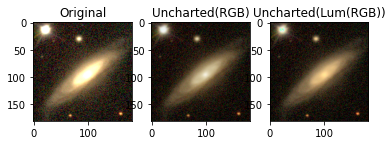

In [4]:
def uncharted(x):
    a = 0.22
    b = 0.30
    c = 0.10
    d = 0.20
    e = 0.01
    f = 0.30

    return ((x * (a * x + c * b) + d * e) / (x * (a * x + b) + d * f)) - e / f

lum = RGB_luminance(rgb, colorspace.primaries, colorspace.whitepoint)
lum_ratio = uncharted(lum)/lum
mapped = rgb* np.expand_dims(lum_ratio, -1)
fig, axs = plt.subplots(1,3)
axs[0].imshow(colour.cctf_encoding(rgb))
axs[0].set_title("Original")
axs[1].imshow(colour.cctf_encoding(uncharted(rgb)))
axs[1].set_title("Uncharted(RGB)")
axs[2].imshow(colour.cctf_encoding(mapped))
axs[2].set_title("Uncharted(Lum(RGB))")
plt.show()

## Galaxy Masking

Something like water shed algorithm 

# Masking 1. Using Scikit-image

* Thresholding 

In [5]:
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color

In [6]:
r,g,b = np.dsplit(rgb, rgb.shape[-1])

r = np.squeeze(r)
g = np.squeeze(g)
b = np.squeeze(b)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


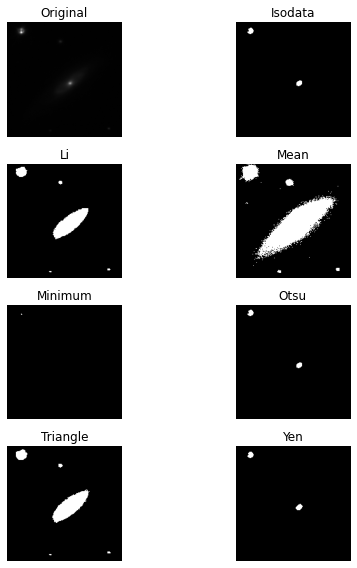

In [7]:
fig, ax = filters.try_all_threshold(r, figsize=(8,8))
plt.show()

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


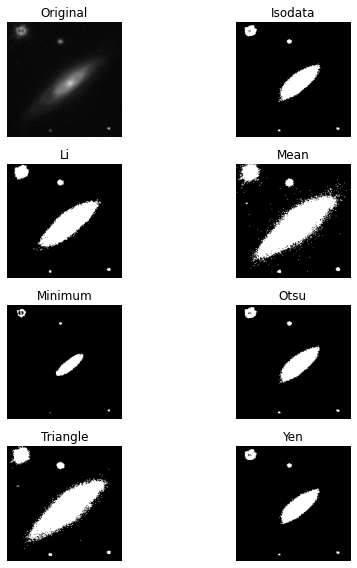

In [8]:
# Tone mapped image
mr = mapped[:,:,0]
fig, ax = filters.try_all_threshold(mr, figsize=(8,8))
plt.show()

In [9]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

Sci-kit image's filters module ships various thresholding methods. But those are some of the most basic (and classic) methods and mostly focus on OCR-like scenario. That is, binary classification of background and obejct with high contrast.  
* filters.threshold_multiotsu can classify multiple objects (i.e., split the intensity histogram into multiple bins)
* _local, _niblack and _sauvola are locally adaptive algorithms




(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

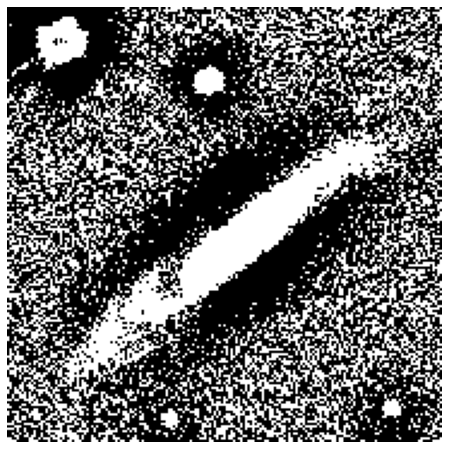

In [10]:
thr = filters.threshold_local(mr, block_size=51)
image_show(mr > thr)

.... OK, thresholding is not going to make it. 

### It's generally a good practive to de-noise the image before segmentation.

In [59]:
# Try some de-noising 

# 1. Active Contour Model / Snakes

Snakes: Active contour models. Kass, M.; Witkin, A.; Terzopoulos, D. International Journal of Computer Vision 1 (4): 321 (1988). DOI:10.1007/BF00133570


Alaha : Rate of snake contraction  
Beta  : smoothness of the snake  
Gamma : ??

In [54]:
from skimage.filters import gaussian
class Ellipse():
    def __init__(self, sma, smi, pa, xc=0, yc=0):
        self.sma = sma
        self.smi = smi
        self.pa = pa
        self.xc = xc
        self.yc = yc
        self.cos = np.cos(self.pa)
        self.sin = np.sin(self.pa)
        
    def gen_points(self, npoints=500):
        
        get_x = lambda theta : self.sma*np.cos(theta)*self.cos - self.smi*np.sin(theta)*self.sin
        get_y = lambda theta : self.sma*np.cos(theta)*self.sin + self.smi*np.sin(theta)*self.cos
        theta = np.linspace(0,2*np.pi,npoints)
    
        return get_x(theta)+self.xc, get_y(theta)+self.yc
        
    def get_dist(self, xx, yy, xc=None, yc=None):
        # Make xc and yc properties
        if not xc is None:
            self.xc = xc
        if not yc is None:
            self.yc = yc
        
        dd = ((xx - self.xc)*self.cos + (yy - self.yc)*self.sin)**2/self.sma**2 +\
             ((yy - self.yc)*self.cos - (xx - self.xc)*self.sin)**2/self.smi**2
        
        return dd
    
    def get_mask(self, nx, ny):
        xpos = np.tile(np.arange(nx),ny)
        ypos = np.repeat(np.arange(ny),nx)
        return ell.get_dist(xpos, ypos).reshape((nx,ny)) > 1
        

In [55]:
gray = color.rgb2gray(mapped)

# Mask ellipse
xc, yc = 98, 95
nx, ny = gray.shape
ell = Ellipse(115, 45, -0.6, xc=xc, yc=yc)
x, y = ell.gen_points()
points = np.stack((x,y)).T

mask_on = ell.get_mask(nx,ny)

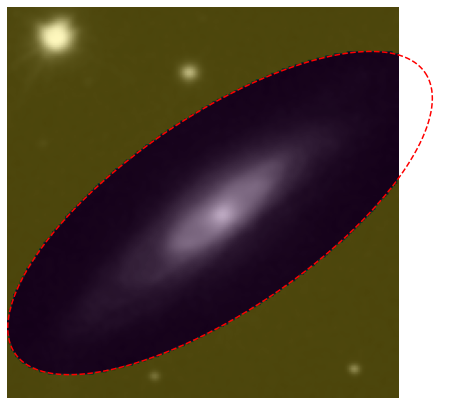

In [56]:
fig, ax = image_show(gaussian(gray, 1))
ax.imshow(mask_on, alpha=0.3)
ax.plot(points[:,0], points[:,1], '--r')
plt.show()

<ipython-input-43-2b27a78747bd>:1: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.
  snake = seg.active_contour(gaussian(gray, 1), points, alpha=0.005, beta=13, gamma=0.004)


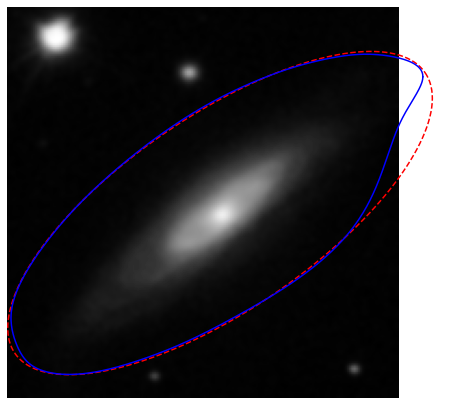

In [43]:
snake = seg.active_contour(gaussian(gray, 1), points, alpha=0.005, beta=13, gamma=0.004)
fig, ax = image_show(gaussian(gray, 1))
ax.plot(points[:,0], points[:,1], '--r')
ax.plot(snake[:,0], snake[:,1], '-b')

# 2. [Morphological Snakes](https://ieeexplore.ieee.org/document/6529072)
Pablo et al. 2014 -- relatively new paper!

Two types are implemented in scikit-image. 
1. Morphological Geodesic Active Contours (MorphGAC)
2. Morphological Active Contours without Edges (MorphACWE)

MoprhGAC works best when the object has a contour (even a noisy one).  
On the other hand, MorphACWE works best when the inner and outer region of object has different mean, which is the case for galaxy images in general. 

In [46]:
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Morphological ACWE
image = gray.copy()
# Put a mask
image[mask_on]=0

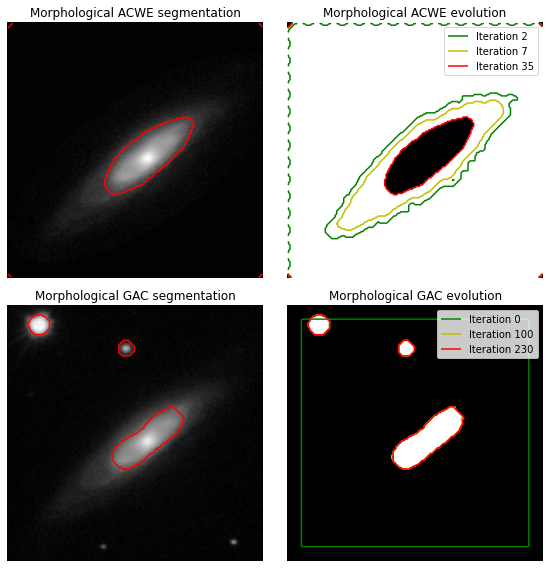

In [47]:
# Initial level set
init_ls = checkerboard_level_set(image.shape, 6)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, 35, init_level_set=init_ls, smoothing=3,
                             iter_callback=callback)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[2], [0.5], colors='g')
contour.collections[0].set_label("Iteration 2")
contour = ax[1].contour(evolution[7], [0.5], colors='y')
contour.collections[0].set_label("Iteration 7")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 35")
ax[1].legend(loc="upper right")
title = "Morphological ACWE evolution"
ax[1].set_title(title, fontsize=12)


# Morphological GAC
image = img_as_float(gray)
gimage = inverse_gaussian_gradient(image)

# Initial level set
init_ls = np.zeros(image.shape, dtype=np.int8)
init_ls[10:-10, 10:-10] = 1
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, 230, init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

ax[2].imshow(image, cmap="gray")
ax[2].set_axis_off()
ax[2].contour(ls, [0.5], colors='r')
ax[2].set_title("Morphological GAC segmentation", fontsize=12)

ax[3].imshow(ls, cmap="gray")
ax[3].set_axis_off()
contour = ax[3].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[3].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[3].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[3].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[3].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

# 3. Random Walker
L.Gardy 2006

DOI:10.1109/TPAMI.2006.233



An anisotropic diffusion equation is solved with tracers initiated at the markers’ position. The local diffusivity coefficient is greater if neighboring pixels have similar values, so that diffusion is difficult across high gradients.

In [115]:
ell = Ellipse(100, 45, -0.6, xc=xc, yc=yc)
mask_s = ell.get_mask(nx,ny)

markers = np.zeros(gray.shape, dtype=np.uint)
thr = np.mean(gray) * 10
markers[gray < thr] = 1
markers[gray > thr] = 2
#markers[mask_s] = 0

Text(0.5, 1.0, 'Segmentation')

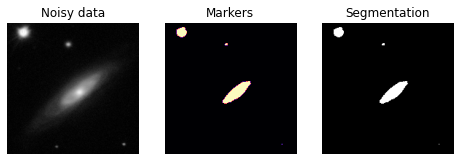

In [116]:
labels = seg.random_walker(gray, markers, beta=10000, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(gray, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')

# 4. SLIC (Simple Linear Iterative Clustering)
Achanta et al. 2012 (10.1109/TPAMI.2012.120)

https://www.epfl.ch/labs/ivrl/research/slic-superpixels/#SLICO

In [127]:
image_slic = seg.slic(rgb, n_segments=51)

<ipython-input-127-b41af1ee560a>:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  image_slic = seg.slic(rgb, n_segments=51)


<ipython-input-128-123302227bf0>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_show(color.label2rgb(image_slic, rgb))#, kind='avg'))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

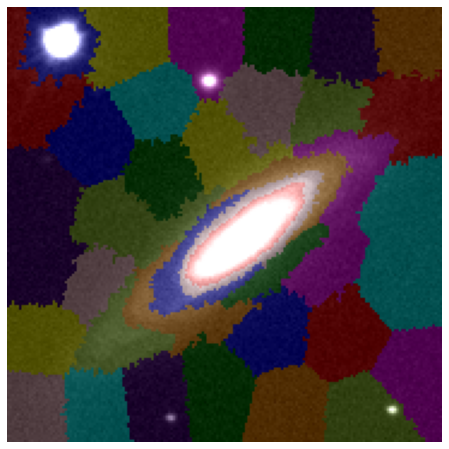

In [128]:
image_show(color.label2rgb(image_slic, rgb))#, kind='avg'))

# 5. Felzenszwalb

Minimum-spanning tree clustering under the hood

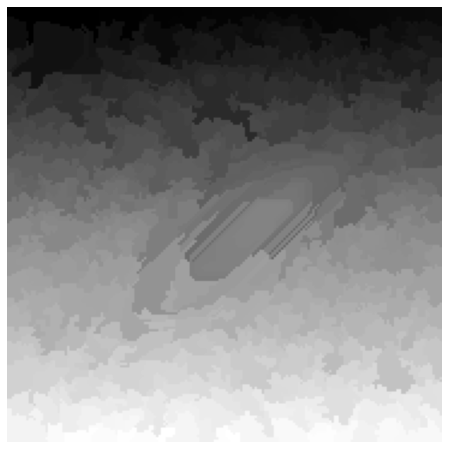

In [130]:
image_felzenszwalb = seg.felzenszwalb(rgb) 
image_show(image_felzenszwalb);

In [132]:
np.unique(image_felzenszwalb).size

445

<ipython-input-133-6859e888b850>:1: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, rgb, kind='avg')
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


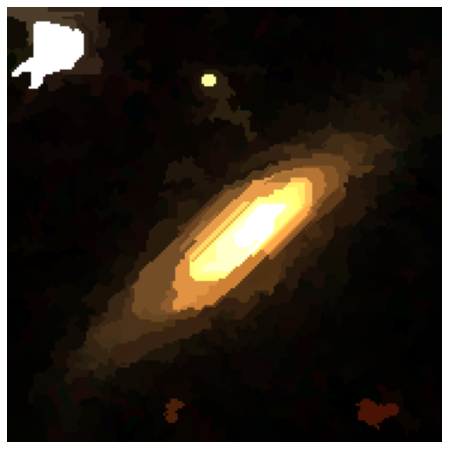

In [133]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, rgb, kind='avg')
image_show(image_felzenszwalb_colored);

In [ ]:
# felizenszwalb tend to 

# 6. Watershed

## Impose min max range 

Lower limit of SNR + ignore pixels saturated by non-galactic source?

In [ ]:
# SNR cut





# Choose saturated pixels





# Mask or what? 

## Try some TMO